In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
%matplotlib inline

## Logic Based FizzBuzz Function [Software 1.0]

In [3]:
def fizzbuzz(n):
    
    # Logic Explanation
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [4]:
def createInputCSV(start,end,filename):
    
    # Why list in Python?
    #Python is readable and simple to use.Data handling is much easier in python.
    #More number of packages are available and are easy to import.
    inputData   = []
    outputData  = []
    
    # Why do we need training Data?
    #Training data is an essential element in ML. Training data is used to train the model,Make the machine understand the data,
    #find Patterns, draw relations and make decisions.
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Why Dataframe?
    #Data frame is a datastructure which looks like a matrix. 
    #It is used in ML since it is easy to visualise, can have different data types in each column
    #Can be easily analysed with column name
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [5]:
def processData(dataset):
    
    # Why do we have to process?
    # To convert the data into understandable format
    # To scale,format and improve the efficiency of the algorithm
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [6]:
import numpy as np

def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10?
        # No. of neurons in input layer is 10 and 
        # Since our training data range is from 101 to 1000,for binary encoding
        # maximum number of bits required to accomodate all input_data is 10
        # performing a bitwise right shift and bitwise and operation.
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [7]:
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

In [8]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


In [9]:
# Read Dataset
trainingData = pd.read_csv('training.csv')
testingData  = pd.read_csv('testing.csv')

# Process Dataset
processedTrainingData, processedTrainingLabel = processData(trainingData)
processedTestingData, processedTestingLabel   = processData(testingData)

## Tensorflow Model Definition

In [10]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 10])
outputTensor = tf.placeholder(tf.float32, [None, 4])

In [11]:
NUM_HIDDEN_NEURONS_LAYER_1 = 1000
LEARNING_RATE = 0.1

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])

# Computing values at the hidden layer
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))
# Computing values at the output layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# Training the Model

In [12]:
NUM_OF_EPOCHS = 4000
BATCH_SIZE = 128

training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    # In tensorflow, in order to use a variable it must be initialized before using it. 
    # Global variable initializer inititalizes all the variables that have been used in the program.
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

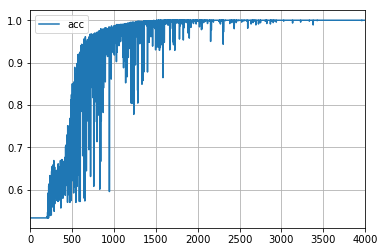

In [13]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [14]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

In [15]:
import matplotlib as matplot

wrong   = 0
right   = 0
fizz_right = 0
fizz_wrong = 0
buzz_right = 0
buzz_wrong = 0
fizzbuzz_right = 0
fizzbuzz_wrong =0 
other_right = 0
other_wrong = 0

predictedTestLabelList = []
""
for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1
    
    if np.argmax(i) == 0:
        if(j == 0):
            other_right = other_right + 1
        else:
            other_wrong = other_wrong + 1
   
    if np.argmax(i) == 1:
        if(j == 1):
            fizz_right = fizz_right + 1
        else:
            fizz_wrong = fizz_wrong + 1
    
    if np.argmax(i) == 2:
        if(j == 2):
            buzz_right = buzz_right + 1
        else:
            buzz_wrong = buzz_wrong + 1
    
    if np.argmax(i) == 3:
        if(j == 3):
            fizzbuzz_right = fizzbuzz_right + 1
        else:
            fizzbuzz_wrong = fizzbuzz_wrong + 1
    
print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))
print("Fizz Accuracy: " + str(fizz_right/(fizz_right+fizz_wrong)*100))
print("Buzz Accuracy: " + str(buzz_right/(buzz_right+buzz_wrong)*100))
print("FizzBuzz Accuracy: " + str(fizzbuzz_right/(fizzbuzz_right+fizzbuzz_wrong)*100))
print("Other Accuracy: " + str(other_right/(other_right+other_wrong)*100))

# Please input your UBID and personNumber 
testDataInput = testingData['input'].tolist()
testDataLabel = testingData['label'].tolist()

testDataInput.insert(0, "UBID")
testDataLabel.insert(0, "dhayanid")

testDataInput.insert(1, "personNumber")
testDataLabel.insert(1, "50290938")

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabelList

for x in range(len(output["label"])):
    if(output["label"][x] == "Other"):
         output["label"][x] = output["input"][x]
         output["predicted_label"][x] = output["input"][x]
        
opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')

Errors: 3  Correct :97
Testing Accuracy: 97.0
Fizz Accuracy: 88.88888888888889
Buzz Accuracy: 100.0
FizzBuzz Accuracy: 100.0
Other Accuracy: 100.0
